# Variational Autoencoder

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from time import time
from tqdm.notebook import tqdm, trange

import os

2023-03-03 15:00:54.899234: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 15:00:55.044074: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-03 15:00:55.662576: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-03 15:00:55.662652: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

## GPU settings

In [2]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

2023-03-03 15:00:57.907909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 15:00:57.910151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 15:00:57.946958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 15:00:57.949055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 15:00:57.951267: I tensorflow/compiler/xla/stream_executo

In [3]:
strategy = tf.distribute.MirroredStrategy(['/gpu:0', '/gpu:1']) # gpu distribution strategy
#strategy = tf.distribute.OneDeviceStrategy(device='/CPU:0')

2023-03-03 15:00:58.139022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2023-03-03 15:00:58.586751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 15:00:58.588373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 15:00:58.590162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 15:00:58.591602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 15:00:58.593259: I tensorflow/compiler/xla/stream_executo

# Implementing actual model
In this chapter we try to implement the variational image compressing model of the paper on the basis of code written above.

## Encoder

In [4]:
class Encoder(tf.keras.layers.Layer):
    """Encoder network for the VAE."""
    
    def __init__(self, N, M, k, format='channel_last'):
        """Initializes the encoder."""
        
        super(Encoder, self).__init__()
        self.N      = N
        self.M      = M
        self.conv1  = tf.keras.layers.Conv2D(self.N, k, strides=2, padding='same', data_format=format)
        self.conv2  = tf.keras.layers.Conv2D(self.N, k, strides=2, data_format=format)
        self.conv3  = tf.keras.layers.Conv2D(self.N, k, strides=1, data_format=format)
        self.conv4  = tf.keras.layers.Conv2D(self.M, k, strides=1, data_format=format)
        self.gdn1   = tfc.layers.GDN()
        self.gdn2   = tfc.layers.GDN()
        self.gdn3   = tfc.layers.GDN()
    
    def call(self, inputs):
        """Forward pass of the encoder."""
        x = self.conv1(inputs)
        x = self.gdn1(x)
        x = self.conv2(x)
        x = self.gdn2(x)
        x = self.conv3(x)
        x = self.gdn3(x)
        z = self.conv4(x)
        del x
        return z

## Hyperprior

In [5]:
class H_a(tf.keras.layers.Layer):
    """Encoder network for the Hyperprior."""
    
    def __init__(self, N, k1, k2, format):
        """Initializes the encoder."""
        
        super(H_a, self).__init__()
        self.N      = N

        self.conv1  = tf.keras.layers.Conv2D(self.N, k1, strides=1, activation='relu', data_format=format)
        self.conv2  = tf.keras.layers.Conv2D(self.N, k2, strides=1, activation='relu', data_format=format)
        self.conv3  = tf.keras.layers.Conv2D(self.N, k2, strides=2, data_format=format)

    def call(self, inputs):
        """Forward pass of the encoder."""
        x = tf.abs(inputs)
        x = self.conv1(x)
        x = self.conv2(x)
        z = self.conv3(x)
        return z


class H_s(tf.keras.layers.Layer):
    """Decocer network for the Hyperprior."""
    
    def __init__(self, N, M, k1, k2, format):
        """Initializes the decoder."""
        
        super(H_s, self).__init__()
        self.N      = N
        self.M      = M
        
        self.conv1  = tf.keras.layers.Conv2DTranspose(self.N, k2, strides=2, activation='relu', data_format=format)
        self.conv2  = tf.keras.layers.Conv2DTranspose(self.N, k2, strides=1, activation='relu', data_format=format)
        self.conv3  = tf.keras.layers.Conv2DTranspose(self.M, k1, strides=1, activation='relu', data_format=format)

    def call(self, inputs):
        """Forward pass of the decoder."""
        x = self.conv1(inputs)
        x = self.conv2(x)
        z = self.conv3(x)
        return z

## Entropy model

In [6]:
def indexes(i):
    return i

def get_indexed_emodel(num_scales):
    return tfc.LocationScaleIndexedEntropyModel(
        prior_fn=tfc.NoisyNormal,
        num_scales=num_scales,
        scale_fn = indexes,
        coding_rank=1,
     )

def get_batched_emodel(batch_shape=()):
    return tfc.ContinuousBatchedEntropyModel(
        prior=tfc.distributions.NoisyDeepFactorized(batch_shape=batch_shape),
        coding_rank=1
    )


## Decoder

In [7]:
class Decoder(tf.keras.layers.Layer):
    """Encoder network for the VAE."""
    
    def __init__(self, N, k, c, format):
        """Initializes the encoder."""
        
        super(Decoder, self).__init__()
        self.N      = N
        self.conv2  = tf.keras.layers.Conv2DTranspose(self.N, k, strides=1, data_format=format)
        self.conv1  = tf.keras.layers.Conv2DTranspose(self.N, k, strides=1, data_format=format)
        self.conv3  = tf.keras.layers.Conv2DTranspose(self.N, k, strides=2, data_format=format, output_padding=(1, 1))
        self.conv4  = tf.keras.layers.Conv2DTranspose(c, k, strides=2, data_format=format, padding='same')
        self.gdn1   = tfc.layers.GDN(inverse=True)
        self.gdn2   = tfc.layers.GDN(inverse=True)
        self.gdn3   = tfc.layers.GDN(inverse=True)
    
    def call(self, inputs):
        """Forward pass of the decoder."""
        x = self.conv1(inputs)
        x = self.gdn1(x)
        x = self.conv2(x)
        x = self.gdn2(x)
        x = self.conv3(x)
        x = self.gdn3(x)
        z = self.conv4(x)
        return z

## Full model

In [8]:
class Balle(tf.keras.Model):
    """Encoder network for the VAE."""
    
    def __init__(self, N, M, k1, k2, c, format):
        """Initializes the encoder."""
        
        super(Balle, self).__init__()

        self.iemodel = get_indexed_emodel(19)
        self.bemodel = get_batched_emodel(())
        self.encoder = Encoder(N, M, k2, format)
        self.decoder = Decoder(N, k2, c, format)
        self.H_a     = H_a(N, k1, k2, format)
        self.H_s     = H_s(N, M, k1, k2, format)


    def call(self, inputs, training = True):

        y = self.encoder(inputs)
        z = self.H_a(y)
        z_tilde, rate_b = self.bemodel(z, training=training)
        sigma = self.H_s(z_tilde)

        y_tilde, rate_i = self.iemodel(y, sigma, training=training)

        x_tilde = self.decoder(y_tilde)

        return x_tilde, rate_i, rate_b
    

class Balle_ff(tf.keras.Model):
    """Encoder network for the VAE."""
    
    def __init__(self, N, M, k1, k2, c, format):
        """Initializes the encoder."""
        
        super(Balle_ff, self).__init__()

        #self.iemodel = get_indexed_emodel(5)
        self.bemodel = get_batched_emodel((19, 19))
        self.encoder = Encoder(N, M, k2, format)
        self.decoder = Decoder(N, k2, c, format)
        self.H_a     = H_a(N, k1, k2, format)
        self.H_s     = H_s(N, M, k1, k2, format)


    def call(self, inputs, training = True):

        y = self.encoder(inputs)

        y_tilde, rate_i = self.bemodel(y, training=training)

        x_tilde = self.decoder(y_tilde)

        return x_tilde, rate_i

# Functions

In [9]:
def read_data_numpy(data_path, format='channels_last'):
    """Read data from file and return a numpy array."""
    with open(data_path, 'rb') as f:
        # read data from file
        X = np.fromfile(f, dtype=np.uint8)
        # reshape data to (num_images, 3, 96, 96)
        X = np.reshape(X, (-1, 3, 96, 96))
        # transpose data to (num_images, 96, 96, 3) to match the image format
        # NOTE that tensorflow may use a different image format (e.g., channels_first: (num_images, 3, 96, 96))
        if format=='channels_last':
            return np.transpose(X, (0, 3, 2, 1))
        elif format=='channels_first':
            return np.transpose(X, (0, 1, 3, 2))
        else:
            print('unrecognized option "'+format+'"')
            return None
    

def visualize_images(images, format):
    """Visualize images in a grid of 4 rows x 4 columns."""
    # Create a list of 16 images by random sampling from the dataset first dimension without replacement
    image_list = [images[i] for i in np.random.choice(images.shape[0], 16, replace=False)]
    if format=='channels_first':
        image_list = [np.transpose(image, (1, 2, 0)) for image in image_list]
    
    # check if the images are normalized
    norm = np.max(image_list) <= 1.0

    # Create a 4x4 grid of images
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if norm:
            ax.imshow(image_list[i]) # no need to convert to uint8
        else:
            ax.imshow(image_list[i].astype(np.uint8)) # convert to uint8 for visualization
        ax.axis('off')

    # Show the plot
    plt.show()

# Constants

In [10]:
DATA_FOLDER = "../data/stl10/stl10_binary/"
DATA_FILE   = "unlabeled_X.bin"

TRAINING_SET_SIZE      = 8_000 # 80,000 images for training -> 20,000 images for validation
VALIDATION_SET_SIZE    = 2_000
BATCH_SIZE_PER_REPLICA = 64 # batch size per gpu replica (e.g., 64 for 1 gpu, 128 for 2 gpus, etc.)
EPOCHS                 = 50


# Code for training

### Load data

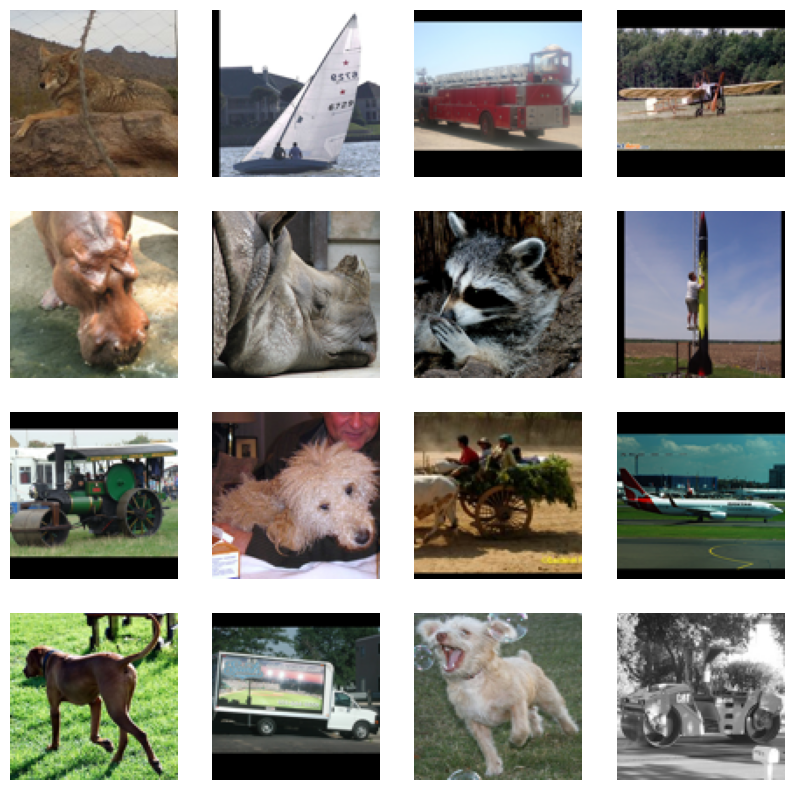

(100000, 3, 96, 96)


In [12]:
data_path = os.path.join(DATA_FOLDER, DATA_FILE)
ch_format = 'channels_first'

data = read_data_numpy(data_path, ch_format)
data = data.astype('float32') / 255.0

visualize_images(data, ch_format)
print(data.shape)

### Split train and test data

In [13]:
train_images = data[:TRAINING_SET_SIZE]
test_images  = data[TRAINING_SET_SIZE:TRAINING_SET_SIZE+VALIDATION_SET_SIZE]

buffer_size       = len(train_images) # buffer size for shuffling
global_batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync # global batch size (in our case 2gpu * BATCH_SIZE_PER_REPLICA)

# create train and test datasets using tf.data API

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_images)).shuffle(buffer_size).batch(global_batch_size)
test_dataset  = tf.data.Dataset.from_tensor_slices(test_images).batch(global_batch_size)

In [22]:
train_dataset_dist = strategy.experimental_distribute_dataset(train_dataset)
test_dataset_dist  = strategy.experimental_distribute_dataset(test_dataset)

2023-03-03 15:14:47.078937: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 8000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3
        }
        dim {
          size: 96
        }
        dim {
          size: 96
        }
      }
      shape {
        dim {
          size: 3
        }
        dim {
          size: 96
        }
        dim {
          size: 96
        }
     

### Create model

In [14]:
# create a VAE model using the strategy scope to distribute the model on multiple gpus
with strategy.scope():
    vae       = Balle(N=128, M=192, k1=3, k2=3, c=3, format=ch_format)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) 

In [26]:
with tf.device('CPU'):
    for inputs in train_dataset:
        test = inputs
        break

test = test[:2]

In [27]:
with tf.device('CPU'):
    enc = Encoder(N=128, M=192, k=3)
    encoded = enc(test, training=False)
encoded

<tf.Tensor: shape=(2, 19, 19, 192), dtype=float32, numpy=
array([[[[-1.95726641e-02,  1.66371884e-03, -1.99822728e-02, ...,
           4.00993079e-02,  1.17860027e-02, -1.41093396e-02],
         [-2.37421561e-02,  1.89929996e-02, -2.00041998e-02, ...,
           2.62626987e-02, -4.46714088e-03, -1.65932477e-02],
         [-3.29300612e-02, -1.51384284e-03, -2.29746737e-02, ...,
           7.08237812e-02,  1.58342551e-02, -3.59048572e-05],
         ...,
         [-2.59402879e-02, -4.76138815e-02, -1.70300864e-02, ...,
           8.97537023e-02, -1.52720055e-02, -7.67924115e-02],
         [-3.66712362e-02, -2.13574190e-02,  2.13133339e-02, ...,
           5.70604429e-02,  1.55839054e-02, -7.71005824e-02],
         [-3.95002738e-02, -1.44896684e-02, -3.35493572e-02, ...,
           8.27543139e-02, -5.98311611e-02, -6.34033158e-02]],

        [[-2.69242004e-02,  3.75283347e-03,  7.94443022e-03, ...,
           4.27341200e-02, -1.83531716e-02, -2.87240185e-02],
         [-4.90659773e-02,  1.

In [32]:
iemod = get_indexed_emodel(5)
iemod(encoded, encoded, training=True)

(<tf.Tensor: shape=(2, 19, 19, 192), dtype=float32, numpy=
 array([[[[-4.71886337e-01, -9.97980461e-02,  2.11889207e-01, ...,
           -1.27841786e-01, -1.27612218e-01, -2.18575567e-01],
          [ 1.92408487e-01,  2.46496186e-01,  2.91149151e-02, ...,
            1.56153262e-01, -4.49226737e-01,  1.03077978e-01],
          [ 2.01972440e-01,  4.26428795e-01, -6.62541986e-02, ...,
           -2.52130389e-01,  2.93464333e-01, -4.39259917e-01],
          ...,
          [-3.76237631e-01,  4.40301746e-01, -2.27989405e-01, ...,
            5.57446778e-01,  2.04527527e-02, -4.71672952e-01],
          [-4.47066247e-01,  3.56742144e-02,  7.75693879e-02, ...,
           -1.04092874e-01, -1.31750315e-01, -4.94987547e-01],
          [ 1.76501006e-01, -4.31940742e-02,  1.07477419e-02, ...,
            1.36303365e-01,  2.64711350e-01, -2.32232034e-01]],
 
         [[-2.19280273e-03, -2.57982612e-01,  2.90946215e-01, ...,
            4.94433373e-01, -2.51483023e-01,  4.68104705e-03],
          [ 3

In [29]:
with tf.device('CPU'):
    de = Decoder(N=128, k=3, c=3)
    decoded = de(encoded, training=False)
decoded

<tf.Tensor: shape=(2, 96, 96, 3), dtype=float32, numpy=
array([[[[-3.3644433e-04,  2.2557864e-04,  2.0931812e-04],
         [-2.7384734e-04, -8.6205476e-04, -8.0388832e-05],
         [ 8.9423964e-04, -5.4745161e-04,  2.5538211e-05],
         ...,
         [ 1.1861175e-03,  1.9443727e-03, -7.8665063e-04],
         [-1.9727360e-05, -2.4652321e-04, -1.8074512e-03],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[-6.8012412e-07,  3.7958366e-06,  4.1502883e-04],
         [ 5.8225571e-05, -2.1523687e-04,  9.5705537e-04],
         [-8.4250665e-04,  4.9701822e-04, -7.6527946e-04],
         ...,
         [-1.2333163e-04,  1.8724956e-04, -3.9516995e-04],
         [ 4.7184603e-04,  7.5509318e-04,  6.7360327e-04],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 8.3261984e-04,  8.6189837e-05,  6.7851273e-04],
         [-4.1912161e-04, -2.0899480e-04, -1.5558200e-03],
         [-5.1362027e-04, -3.8718196e-04,  2.8609199e-04],
         ...,
         [ 6.

In [33]:
with tf.device('CPU'):
    ha = H_a(128, 3, 3)
    result = ha(encoded, training=False)
result

<tf.Tensor: shape=(2, 7, 7, 128), dtype=float32, numpy=
array([[[[ 5.00360839e-02,  6.29077340e-03,  2.13344079e-02, ...,
          -2.53036898e-02, -5.80823282e-04, -1.20970169e-02],
         [ 4.58801836e-02,  1.27340597e-03,  2.30967570e-02, ...,
          -3.26591320e-02, -1.27032204e-02, -2.99995244e-02],
         [ 6.13363571e-02, -8.09384976e-03,  1.31245945e-02, ...,
          -4.39811051e-02, -9.70210787e-03, -2.54718885e-02],
         ...,
         [ 6.31682649e-02,  6.19347254e-03,  3.09893358e-02, ...,
          -3.50924470e-02, -1.91199675e-03, -3.66221815e-02],
         [ 6.10363111e-02, -5.23724477e-04,  3.55254114e-02, ...,
          -3.97978872e-02, -5.67238359e-03, -2.78134644e-02],
         [ 5.26602417e-02, -6.36224111e-04,  1.74443517e-02, ...,
          -3.98615263e-02, -1.12179397e-02, -3.46512683e-02]],

        [[ 5.17416410e-02,  2.31082528e-03,  7.81984162e-03, ...,
          -2.30447315e-02, -4.53620523e-05, -2.99629830e-02],
         [ 4.98894416e-02, -4.74

In [38]:
bemod = get_batched_emodel(())
bemod(result, training=True)

(<tf.Tensor: shape=(2, 7, 7, 128), dtype=float32, numpy=
 array([[[[-2.94399142e-01,  4.82595414e-01, -1.17030025e-01, ...,
           -1.02539748e-01,  4.19303216e-03,  1.12183914e-01],
          [ 3.41340899e-01,  3.32836747e-01,  3.99663299e-01, ...,
           -1.21051267e-01,  3.38275403e-01, -3.30791771e-02],
          [-1.51580378e-01, -4.62349206e-01,  1.73807517e-01, ...,
           -4.62265044e-01,  4.67777580e-01, -2.21513599e-01],
          ...,
          [ 3.66891474e-01, -3.58220994e-01, -3.28787744e-01, ...,
           -2.23657340e-01, -3.27185273e-01,  5.45492023e-02],
          [ 3.26326698e-01, -8.94062892e-02, -3.81381899e-01, ...,
           -3.72395873e-01, -9.46771353e-02,  3.16881508e-01],
          [-2.89478421e-01, -1.05682023e-01,  1.00531913e-01, ...,
            3.88486296e-01, -5.06275177e-01, -3.01467896e-01]],
 
         [[ 4.27663714e-01,  1.59681514e-01,  3.24673712e-01, ...,
           -3.67437869e-01, -4.10318553e-01,  2.79207379e-01],
          [-1.1

In [31]:
with tf.device('CPU'):
    hs = H_s(128, 192, 3, 3)
    result = hs(result, training=False)
result

<tf.Tensor: shape=(2, 19, 19, 192), dtype=float32, numpy=
array([[[[2.91395525e-04, 0.00000000e+00, 4.37319744e-04, ...,
          3.95348616e-05, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.03649870e-03, 1.10373425e-04, ...,
          8.14009458e-04, 3.94858333e-04, 0.00000000e+00],
         [0.00000000e+00, 1.65671692e-03, 8.72405479e-04, ...,
          8.06809461e-04, 0.00000000e+00, 0.00000000e+00],
         ...,
         [6.33307151e-04, 7.47887185e-04, 1.06095488e-03, ...,
          0.00000000e+00, 0.00000000e+00, 1.53351924e-03],
         [0.00000000e+00, 8.41105415e-04, 0.00000000e+00, ...,
          0.00000000e+00, 4.37676877e-04, 7.14887501e-05],
         [9.61757731e-04, 0.00000000e+00, 1.54823923e-04, ...,
          1.02127946e-04, 0.00000000e+00, 1.30188116e-03]],

        [[3.05807480e-04, 0.00000000e+00, 0.00000000e+00, ...,
          1.02227379e-03, 0.00000000e+00, 4.26473212e-04],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         

### Training

In [31]:
with strategy.scope():
  @tf.function
  def loss(inputs, outputs):
    
    return tf.reduce_mean(tf.square(inputs - outputs[0])) + 0.5*(tf.reduce_mean(outputs[1])+tf.reduce_mean(outputs[2]))

  @tf.function
  def compute_loss(labels, predictions):
    per_example_loss = loss(labels, predictions)
    return tf.nn.compute_average_loss(per_example_loss, global_batch_size=global_batch_size)

In [32]:
with strategy.scope():
    @tf.function # compile the function to a graph for faster execution
    def train_step(inputs, vae):
        """Train step function."""
        print('Inside train step')
        with tf.GradientTape() as tape: # create a tape to record operations
            
            reconstructed, ratei, rateb = vae(inputs) # forward pass
            print('calculated reconstructed')
            loss          = compute_loss(inputs, (reconstructed, ratei, rateb)) # MSE loss (maybe put this in a function)
            print('computed loss')
        gradients = tape.gradient(loss, vae.trainable_variables) # compute gradients    
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables)) # gradient descent
        print('applied gradients')
        return loss # return loss for logging


In [33]:
for epoch in range(EPOCHS):
    total_loss = 0.0 
    num_batches = 0 
    for inputs, _ in tqdm(train_dataset_dist, 'training steps'): 
        loss = strategy.run(train_step, args=(inputs, vae)) # distributed training
        print('finished training step')
        total_loss += strategy.reduce(tf.distribute.ReduceOp.SUM, loss, axis=None) # sum losses across replicas
        num_batches += 1 # count number of batches
    train_loss = total_loss / num_batches # compute average loss
    print('Epoch {} train loss: {}'.format(epoch, train_loss))

    total_loss = 0.0
    num_batches = 0
    for inputs, _ in tqdm(test_dataset_dist, 'validation steps'): 
        reconstructed = vae(inputs, training=False) # forward pass
        loss = tf.reduce_mean(tf.square(inputs - reconstructed)) # MSE loss
        total_loss += strategy.reduce(tf.distribute.ReduceOp.SUM, loss, axis=None) # sum losses across replicas
        num_batches += 1 # count number of batches
    test_loss = total_loss / num_batches # compute average loss
    print('Epoch {} test loss: {}'.format(epoch, test_loss))

training steps: 0it [00:00, ?it/s]

Inside train step
calculated reconstructed
INFO:tensorflow:Error reported to Coordinator: in user code:

    File "/tmp/ipykernel_258252/2142914735.py", line 10, in train_step  *
        loss          = compute_loss(inputs, (reconstructed, ratei, rateb)) # MSE loss (maybe put this in a function)
    File "/tmp/ipykernel_258252/3967016213.py", line 10, in compute_loss  *
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=global_batch_size)
    File "/home/ubuntu/data/miniconda3/envs/tf/lib/python3.10/contextlib.py", line 135, in __enter__
        return next(self.gen)

    ValueError: Invalid value passed for `per_example_loss`. Expected a tensor with at least rank 1. Received per_example_loss=Tensor("PartitionedCall:0", shape=(), dtype=float32) with rank 0
Traceback (most recent call last):
  File "/home/ubuntu/data/miniconda3/envs/tf/lib/python3.10/site-packages/tensorflow/python/training/coordinator.py", line 293, in stop_on_exception
    yield
  File "/hom

ValueError: in user code:

    File "/tmp/ipykernel_258252/2142914735.py", line 10, in train_step  *
        loss          = compute_loss(inputs, (reconstructed, ratei, rateb)) # MSE loss (maybe put this in a function)
    File "/tmp/ipykernel_258252/3967016213.py", line 10, in compute_loss  *
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=global_batch_size)
    File "/home/ubuntu/data/miniconda3/envs/tf/lib/python3.10/contextlib.py", line 135, in __enter__
        return next(self.gen)

    ValueError: Invalid value passed for `per_example_loss`. Expected a tensor with at least rank 1. Received per_example_loss=Tensor("PartitionedCall:0", shape=(), dtype=float32) with rank 0


## Training with model compile and fit

In [17]:
with strategy.scope():
    vae       = Balle(N=128, M=192, k1=3, k2=3, c=3, format=ch_format)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) 

    def loss(inputs, outputs):
        print('outputs:', outputs.shape, '\ninputs:', inputs.shape)
        return tf.reduce_mean(tf.square(inputs - outputs[0])) + 0.5*(tf.reduce_mean(outputs[1])+tf.reduce_mean(outputs[2]))
        

vae.compile(optimizer=optimizer, loss=loss)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [18]:
vae.fit(train_dataset)

2023-03-03 15:03:29.947843: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 8000
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 3
        }
        dim {
          size: 96
        }
        dim {
          size: 96
        }
      }
      shape {
        dim {
          size: 3
        }
        dim {
          size: 96
        }
        dim {
          size: 96
        }
     

outputs: (None, 3, 96, 96) 
inputs: (None, 3, 96, 96)
outputs: (None, 192, 19) 
inputs: (None, 3, 96, 96)
INFO:tensorflow:Error reported to Coordinator: in user code:

    File "/tmp/ipykernel_258252/389013783.py", line 7, in loss  *
        return tf.reduce_mean(tf.square(inputs - outputs[0])) + 0.5*(tf.reduce_mean(outputs[1])+tf.reduce_mean(outputs[2]))

    ValueError: Dimensions must be equal, but are 96 and 192 for '{{node loss_1/sub}} = Sub[T=DT_FLOAT](cond/Identity_2, loss_1/strided_slice)' with input shapes: [?,3,96,96], [192,19].
Traceback (most recent call last):
  File "/home/ubuntu/data/miniconda3/envs/tf/lib/python3.10/site-packages/tensorflow/python/training/coordinator.py", line 293, in stop_on_exception
    yield
  File "/home/ubuntu/data/miniconda3/envs/tf/lib/python3.10/site-packages/tensorflow/python/distribute/mirrored_run.py", line 386, in run
    self.main_result = self.main_fn(*self.main_args, **self.main_kwargs)
  File "/home/ubuntu/data/miniconda3/envs/tf/lib/p

ValueError: in user code:

    File "/home/ubuntu/data/miniconda3/envs/tf/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_258252/389013783.py", line 7, in loss  *
        return tf.reduce_mean(tf.square(inputs - outputs[0])) + 0.5*(tf.reduce_mean(outputs[1])+tf.reduce_mean(outputs[2]))

    ValueError: Dimensions must be equal, but are 96 and 192 for '{{node loss_1/sub}} = Sub[T=DT_FLOAT](cond/Identity_2, loss_1/strided_slice)' with input shapes: [?,3,96,96], [192,19].
